In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root=r'C:\deep\chap13\data', train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root=r'C:\deep\chap13\data', train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [4]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x
    
        

In [5]:
encoder = Encoder(encoded_space_dim=4, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=4, fc2_input_dim=128)
encoder.to(device)
decoder.to(device)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)
loss_fn = torch.nn.MSELoss()

In [6]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)
        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_noisy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [7]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [8]:
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

In [9]:
from matplotlib import font_manager
font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

In [10]:
def plot_ae_outputs(encoder, decoder, n=5, noise_factor=0.3):
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        ax = plt.subplot(3, n, i+1)
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img, noise_factor)
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(image_noisy))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('원래 이미지')
        ax = plt.subplot(3, n, i+1+n)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('노이즈가 적용되어 손상된 이미지')
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('재구성된 이미지')

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.7, top=0.9, wspace=0.3, hspace=0.3)
    plt.show()

EPOCH 1/3

 EPOCH 1/3 	 train loss 0.077 	 val loss 0.048


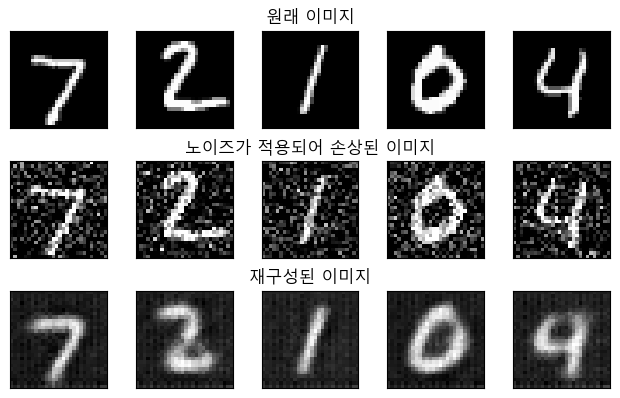

EPOCH 2/3

 EPOCH 2/3 	 train loss 0.054 	 val loss 0.043


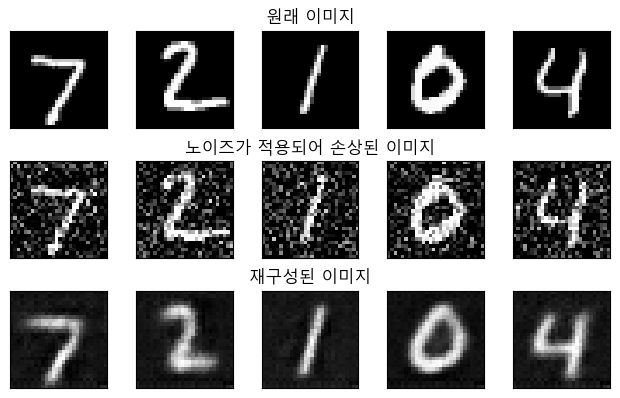

EPOCH 3/3

 EPOCH 3/3 	 train loss 0.053 	 val loss 0.042


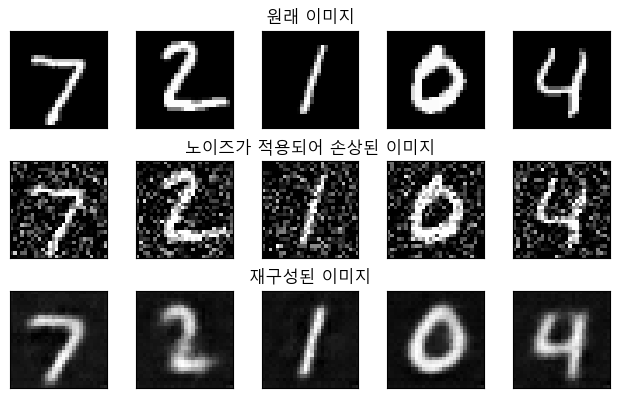

In [12]:
import numpy as np

num_epochs = 3
history_da = {'train_loss':[], 'val_loss':[]}
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    train_loss=train_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=train_loader,
        loss_fn=loss_fn,
        optimizer=optim, noise_factor=0.3)

    val_loss = test_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=train_loader,
        loss_fn=loss_fn, noise_factor=0.3)

    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs, train_loss, val_loss))
    plot_ae_outputs(encoder, decoder, noise_factor=0.3)

In [13]:
%pip install tensorboardX


   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 2/2 [tensorboardX]

Note: you may need to restart the kernel to use updated packages.


In [15]:
import datetime
import os
from tensorboardX import SummaryWriter
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root=r'C:\deep\chap13\data', train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root=r'C:\deep\chap13\data', train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=4)

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        h_ = self.LeakyReLU(self.input1(x))
        h_ = self.LeakyReLU(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)
        return mean, log_var

In [19]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.hidden1(x))
        h = self.LeakyReLU(self.hidden2(h))
        x_hat = torch.sigmoid(self.output(h))
        return x_hat

In [20]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [21]:
x_dim = 784
hidden_dim = 400
latent_dim = 200
epochs = 3
batch_size = 100

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [23]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [25]:
saved_loc = 'scalar/'
writer = SummaryWriter(saved_loc)

model.train()

def train(epoch, model, train_loader, optimizer):
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        BCE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = BCE + KLD
        writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size))
        writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size))
        writer.add_scalar("Train/Total Loss", loss.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size))

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(x)))

    print("====> Epoch: {} Average loss: {:.4f}".format(epoch, train_loss / len(train_loader.dataset)))

In [28]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)
            x_hat, mean, log_var = model(x)
            BCE, KLD = loss_function(x, x_hat, mean, log_var)
            loss = BCE + KLD

            writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size))
            writer.add_scalar("Test/Total Loss", loss.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size))
            test_loss += loss.item()

            if batch_idx == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
                grid = torchvision.utils.make_grid(comparison.cpu())
                writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)

In [29]:
from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
    print("\n")
writer.close()

  0%|          | 0/3 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%]	 Loss: 135.598730
Train Epoch: 0 [10000/60000 (17%]	 Loss: 131.254121
Train Epoch: 0 [20000/60000 (33%]	 Loss: 126.130420
Train Epoch: 0 [30000/60000 (50%]	 Loss: 124.654336
Train Epoch: 0 [40000/60000 (67%]	 Loss: 122.470879
Train Epoch: 0 [50000/60000 (83%]	 Loss: 121.166660
====> Epoch: 0 Average loss: 128.8248


Train Epoch: 1 [0/60000 (0%]	 Loss: 121.663672
Train Epoch: 1 [10000/60000 (17%]	 Loss: 117.662393
Train Epoch: 1 [20000/60000 (33%]	 Loss: 114.820869
Train Epoch: 1 [30000/60000 (50%]	 Loss: 122.706494
Train Epoch: 1 [40000/60000 (67%]	 Loss: 115.524844
Train Epoch: 1 [50000/60000 (83%]	 Loss: 115.982861
====> Epoch: 1 Average loss: 117.6164


Train Epoch: 2 [0/60000 (0%]	 Loss: 116.749561
Train Epoch: 2 [10000/60000 (17%]	 Loss: 106.639492
Train Epoch: 2 [20000/60000 (33%]	 Loss: 115.162988
Train Epoch: 2 [30000/60000 (50%]	 Loss: 111.995518
Train Epoch: 2 [40000/60000 (67%]	 Loss: 113.696787
Train Epoch: 2 [50000/60000 (83%]	 Loss: 106.668857

In [32]:
%pip install tensorboard

   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   ------------- -------------------------- 1.8/5.5 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 5.5/5.5 MB 17.7 MB/s  0:00:00
   ---------------------------------------- 0.0/4.7 MB ? eta -:--:--
   ---------------------------------------- 4.7/4.7 MB 35.6 MB/s  0:00:00

   ---------------------------------------- 0/6 [werkzeug]
   ------------- -------------------------- 2/6 [grpcio]
   -------------------------- ------------- 4/6 [markdown]
   --------------------------------- ------ 5/6 [tensorboard]
   --------------------------------- ------ 5/6 [tensorboard]
   --------------------------------- ------ 5/6 [tensorboard]
   --------------------------------- ------ 5/6 [tensorboard]
   ---------------------------------------- 6/6 [tensorboard]

Note: you may need to restart the kernel to use updated packages.


In [33]:
%load_ext tensorboard
%tensorboard --logdir scalar --port=6013

In [35]:
%pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [38]:
import imageio
from tqdm import tqdm
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
plt.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
batch_size = 512
epochs = 10
sample_size = 64
nz = 128
k = 1

In [42]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),])

train_dataset = datasets.MNIST(
    root=r'C:\deep\chap13\data', train=True, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [43]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [44]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [45]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [46]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = []
losses_d = []
images = []

In [47]:
def save_generator_image(image, path):
    save_image(image, path)

In [48]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [49]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [62]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    generated_img = make_grid(generated_img)
    save_generator_image(generated_img, f"C:\deep\chap13\img\gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / idx
    epoch_loss_d = loss_d / idx
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:10, 11.07it/s]                                                                             


Epoch 0 of 10
Generator loss: 3.39680386, Discriminator loss: 1.24028313


118it [00:10, 11.17it/s]                                                                             


Epoch 1 of 10
Generator loss: 7.31200027, Discriminator loss: 0.12651759


118it [00:10, 11.15it/s]                                                                             


Epoch 2 of 10
Generator loss: 4.20301437, Discriminator loss: 0.76310885


118it [00:11, 10.35it/s]                                                                             


Epoch 3 of 10
Generator loss: 12.85320663, Discriminator loss: 0.90126622


118it [00:11, 10.09it/s]                                                                             


Epoch 4 of 10
Generator loss: 13.77352238, Discriminator loss: 0.72863233


118it [00:10, 10.93it/s]                                                                             


Epoch 5 of 10
Generator loss: 2.37614632, Discriminator loss: 0.89077914


118it [00:10, 11.08it/s]                                                                             


Epoch 6 of 10
Generator loss: 2.82071805, Discriminator loss: 0.91268808


118it [00:10, 11.08it/s]                                                                             


Epoch 7 of 10
Generator loss: 1.50445509, Discriminator loss: 0.98833895


118it [00:11, 10.61it/s]                                                                             


Epoch 8 of 10
Generator loss: 3.02578449, Discriminator loss: 0.77123630


118it [00:10, 11.03it/s]                                                                             

Epoch 9 of 10
Generator loss: 2.36452866, Discriminator loss: 0.88242209


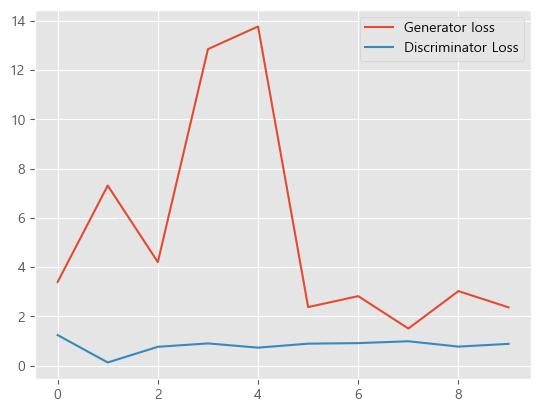

In [63]:
plt.figure()
losses_g = [fl.item() for fl in losses_g]
plt.plot(losses_g, label='Generator loss')
losses_d = [f2.item() for f2 in losses_d]
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()

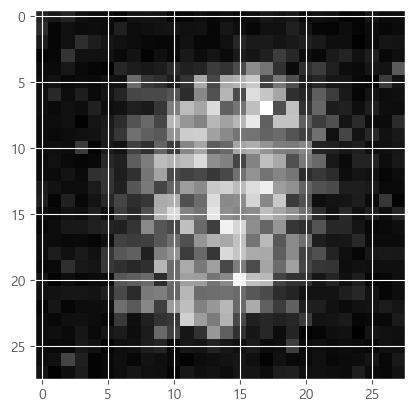

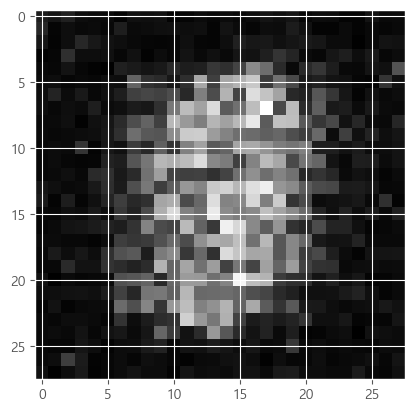

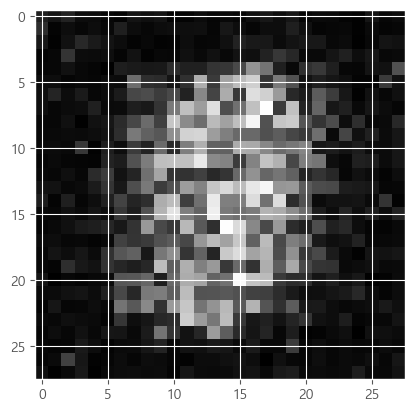

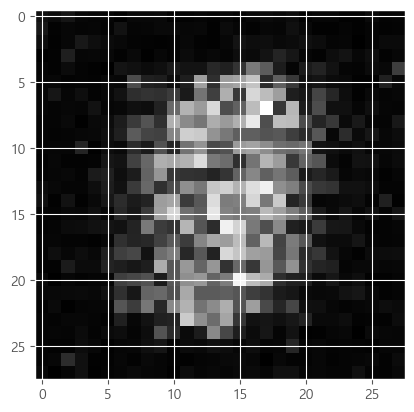

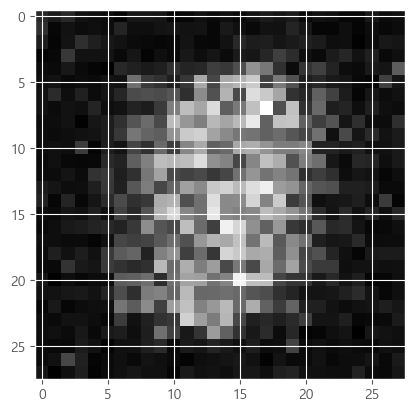

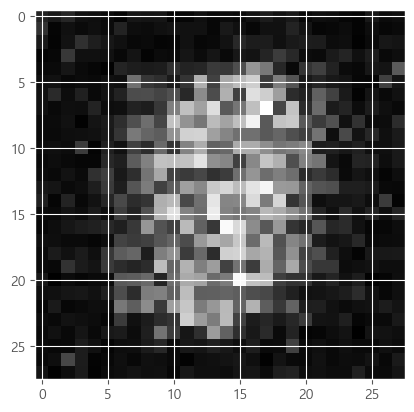

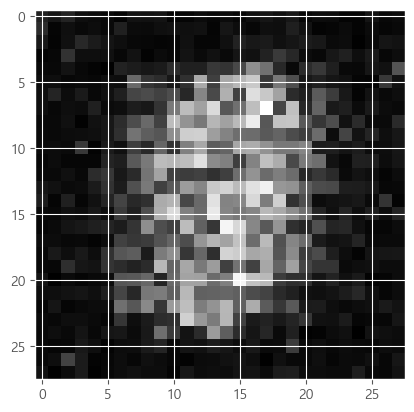

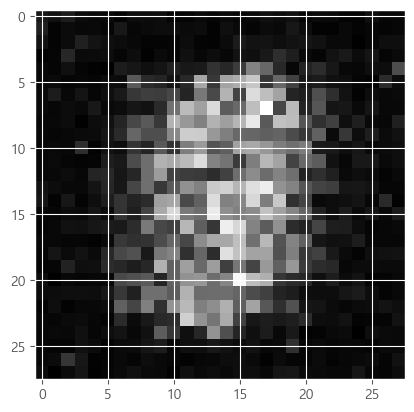

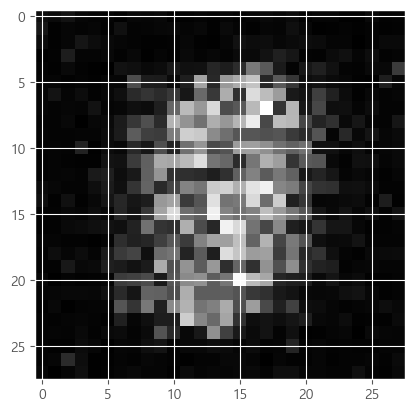

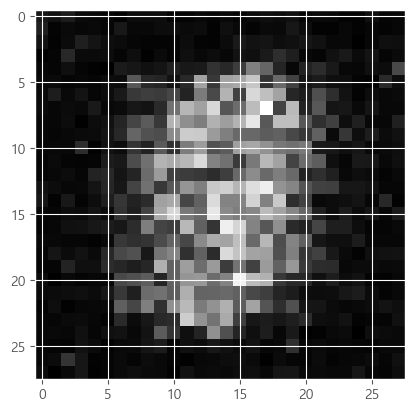

In [64]:
fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap='gray')
    plt.savefig(r'C:\deep\chap13\img\fake_images_img' + str(i) + '.png')
    plt.show()